# Calling and Processing Data

This markdown file contains code to call an estimate for the number of tweets likely to be called by our search terms throughout the period we are interested in. It does this by utilizing the Search API Counts endpoint. This code is adapted from the following page: https://github.com/twitterdev/search-tweets-python/blob/master/examples/api_example.ipynb

## Import Packages & Define Key Variables

In [1]:
# Import packages
import yaml
import json
import pandas as pd
import numpy as np
from searchtweets import ResultStream, gen_rule_payload, load_credentials, collect_results
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import json_lines
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import csv
import demoji
demoji.download_codes()

# Define rootpath
rp = 'C:\\Users\\sgmmahon\\Documents\\GitHub\\iom_project\\'
mp = 'methods\\accessing_tweets\\'
dp = 'data\\tweet_data\\'     

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sgmmahon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sgmmahon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sgmmahon\AppData\Roaming\nltk_data...


[nltk_data]   Package punkt is already up-to-date!


... OK (Got response in 0.35 seconds)
Writing emoji data to C:\Users\sgmmahon\.demoji\codes.json ...
... OK


## Setup Premium Twitter Key

In [2]:
### Define YAML with key details for accessing Twitter API
config = dict(
    search_tweets_api=dict(
        account_type='premium',
        endpoint=f"https://api.twitter.com/1.1/tweets/search/fullarchive/datacollection.json",
        consumer_key='VzihIPxv5oFrd3SkNuBuQk9o3',
        consumer_secret='Iq7hi4K1cZnzgD3RC1miTM6rcrHMA4aeHj3OeCsI9OvFVtX5Ej'
    )
)


# Save YAML file
with open(rp + mp + 'twitter_keys.yaml', 'w') as config_file:
    yaml.dump(config, config_file, default_flow_style=False)

# Define rules for premium search for streaming tweets
premium_search_args = load_credentials(rp + mp + 'twitter_keys.yaml',
                                       yaml_key="search_tweets_api",
                                       env_overwrite=False)

Grabbing bearer token from OAUTH


## Define Search Terms

In [3]:
# Create functions which concatenates vectors
def cnct (x): return(" OR ".join(x))
def cnctwb (x): return("(" + " OR ".join(x) + ")")

In [4]:
# UK Search Terms

# Migrant terms
uk_neutral_migrant_terms  = ["immigrant", "immigration", "migrant", "migration", "\"asylum seeker\"", "refugee", "\"undocumented worker\"", "\"guest worker\"", 
                             "\"EU worker\"", "\"non-UK workers\"", "\"foreign worker\"", "(human smuggling)", "(human trafficking)"]
uk_negative_migrant_terms = ["illegals", "foreigner", "\"illegal alien\"", "\"illegal worker\""]
 
# Racial terms
uk_negative_racial_terms  = ["islamophob", "sinophob", "\"china flu\"", "\"kung flu\"", "\"china virus\"", "\"chinese virus\"", "shangainese"]

# Twitter accounts
uk_pro_migrant_account_1  = ["@UNmigration", "@IOM_UN", "@IOMatUN", "@IOMatEU", "@IOM_UK", "@IOMResearch", "@IOM_GMDAC", "@hrw", "@Right_to_Remain",
                             "@CommonsHomeAffs", "@fcukba", "@Mark_George_QC", "@MigrantVoiceUK", "@MigrantChildren", "@MigrantHelp", "@thevoiceofdws"]
uk_pro_migrant_account_2  = ["@WORCrights", "@UbuntuGlasgow", "@MigrantsUnionUK", "@migrants_rights", "@MigrantsMRC", "@Consenant_UK", "@RomaSupport",
                             "@MigrantsLawProj", "@MigRightsScot", "@IRMOLondon", "@HighlySkilledUK", "@WeBelong19", "@Project17UK"]
uk_neutral_account        = ["@ukhomeoffice", "@pritipatel", "@UKHomeSecretary", "@EUHomeAffairs", "@MigrMatters", "@MigObs"]
uk_anti_migrant_account   = ["@Nigel_Farage", "@MigrationWatch"]

# Hashtags
uk_positive_hashtags      = ["#RefugeesWelcome", "#MigrantsWelcome", "#LeaveNoOneBehind", "#FreedomForImmigrants", "#illegalmigantsUK", "#LondonIsOpen",
                             "#EndHostileEnvironment", "#FamiliesBelongTogether"]
uk_neutral_hashtags       = ["#Pritiuseless", "#migrationEU", "#immigration", "#migration", "#immigrant", "#migrant", "#immigrate", "#migrate", "#refugees",
                             "#NigelFarage", "#ImmigrationReform"]
uk_negative_hashtags      = ["#illegals", "#foreigner", "#foreigners", "#illegalalien", "#illegalaliens", "#illegalworker", "#illegalworkers", "#KeepThemOut",
                             "#OurCountry", "#SendThemBack", "#migrantsnotwelcome", "#refugeesnotwelcome", "#illegals", "#ChinaVirus", "#chinaflu", "#kungflu",
                             "#chinesevirus", "#TheyHaveToGoBack", "#DeportThemAll"]
uk_event_hashtags         = ["#Moria", "#CampFire", "#closethecamps"]

# Define final search queries
uk_terms    = cnctwb([cnct(uk_neutral_migrant_terms), cnct(uk_negative_migrant_terms), cnct(uk_negative_racial_terms)])
uk_accounts = cnctwb([cnct(uk_pro_migrant_account_1), cnct(uk_pro_migrant_account_2), cnct(uk_neutral_account), cnct(uk_anti_migrant_account)])
uk_hashtags = cnctwb([cnct(uk_positive_hashtags), cnct(uk_neutral_hashtags), cnct(uk_negative_hashtags), cnct(uk_event_hashtags)])

# Append all search term into single list
uk_search_terms = uk_neutral_migrant_terms + uk_negative_migrant_terms + uk_negative_racial_terms + uk_pro_migrant_account_1 + \
                  uk_pro_migrant_account_2 + uk_neutral_account + uk_positive_hashtags + uk_neutral_hashtags + uk_negative_hashtags + uk_event_hashtags


# USA Search Terms

# Migrant terms
usa_neutral_migrant_terms  = ["immigrant", "immigration", "migrant", "migration", "\"asylum seeker\"", "refugee", "\"undocumented worker\"", "\"guest worker\"", 
                              "\"foreign worker\"", "(human smuggling)", "(human trafficking)"]
usa_negative_migrant_terms = ["illegals", "foreigner", "\"illegal alien\"", "\"illegal worker\""]
 
# Racial terms
usa_negative_racial_terms  = ["islamophob", "sinophob", "\"china flu\"", "\"kung flu\"", "\"china virus\"", "\"chinese virus\"", "shangainese"]

# Twitter accounts
usa_pro_migrant_account_1  = ["@UNmigration", "@IOM_UN", "@IOMatUN", "@IOMatEU", "@IOM_UK", "@IOMResearch", "@IOM_GMDAC", "@hrw", "@NIJC", "@CIYJA", 
                              "@ImmAdvocates", "@NWIRP", "@RAICESTEXAS", "@ImmJusticeNOW", "@icirr", "@IAmAnImmigrant", "@Am4ImmJustice", "@NILCJusticeFund"]
usa_pro_migrant_account_2  = ["@CIRCimmigrant", "@FLImmigrant", "@ImmFamTogether", "@ImmJustice", "@NICE4Workers", "@CA4ImmiJustice", "@immigrantarc", "@Join_SIM",
                              "@SDIRC", "@RMIAN_org", "@NJAIJ", "@NVImmigrants", "@VA_Immigrants"]
usa_neutral_account        = ["@ICEgov", "@PhillyOIA", "@iandraffairs", "@LAC4Immigrants", "@CoreCivic"]
usa_anti_migrant_account   = ["@EuropidWhites"]

# Hashtags
usa_positive_hashtags      = ["#RefugeesWelcome", "#MigrantsWelcome", "#LeaveNoOneBehind", "#FreedomForImmigrants", "#illegalmigantsUSA", "#KillTheImmigrationBill", 
                              "#ImmigrantsMakeAmericaGreat", "#NoWall", "#NoWallEver", "#NoBan", "#FamiliesBelongTogether", "#stopICEcold", "#EndRemainInMexico"]
usa_neutral_hashtags       = ["#ICE", "#immigration", "#migration", "#immigrant", "#migrant", "#immigrate", "#migrate", "#refugees", "#ImmigrationReform"]
usa_negative_hashtags      = ["#illegals", "#foreigner", "#foreigners", "#illegalalien", "#illegalaliens", "#illegalworker", "#illegalworkers", "#KeepThemOut",
                              "#OurCountry", "#SendThemBack", "#migrantsnotwelcome", "#refugeesnotwelcome", "#illegals", "#ChinaVirus", "#chinaflu", "#kungflu",
                              "#chinesevirus", "#TheyHaveToGoBack", "#DeportThemAll"]
usa_event_hashtags         = ["#Moria", "#closethecamps", "#divestfromdetention"]

# Define final search queries
usa_terms    = cnctwb([cnct(usa_neutral_migrant_terms), cnct(usa_negative_migrant_terms), cnct(usa_negative_racial_terms)])
usa_accounts = cnctwb([cnct(usa_pro_migrant_account_1), cnct(usa_pro_migrant_account_2), cnct(usa_neutral_account), cnct(usa_anti_migrant_account)])
usa_hashtags = cnctwb([cnct(usa_positive_hashtags), cnct(usa_neutral_hashtags), cnct(usa_negative_hashtags), cnct(usa_event_hashtags)])

# Append all search term into single list
usa_search_terms = usa_neutral_migrant_terms + usa_negative_migrant_terms + usa_negative_racial_terms + usa_pro_migrant_account_1 + \
                   usa_pro_migrant_account_2 + usa_neutral_account + usa_positive_hashtags + usa_neutral_hashtags + usa_negative_hashtags + usa_event_hashtags



# Spain Search Terms

# Migrant terms
spain_neutral_migrant_terms  = ["migraci", "migrante", "refugiad", "migratorio", "refugiada", "discrimin", "extranjer", "xenofo"]
spain_negative_migrant_terms = ["racista", "deporta", "legal", "patriota", "racismo", "invasores"]
 
# Racial terms
spain_negative_racial_terms  = ["musulman", "islamofobia", "marroquí"]

# Twitter accounts
spain_pro_migrant_account_1  = ["@UNmigration", "@IOM_UN", "@IOMatUN", "@IOMatEU", "@IOMPOS", "@IOMResearch", "@IOM_GMDAC", "@hrw", "@IOMspain", "@FundacionMigrar",
                                "@inclusiongob", "@CooperacionAND", "@migrantes_sj"]
spain_pro_migrant_account_2  = ["@PMigraciones", "@walkingborders", "@CanalMigrantes", "@RegularizacionY", "@RSAcogida", "@campsoscar", "@openarms_fund", "@APDHA",
                                "@TrasLaManta", "@EspacioInmigran", "@CIEsNoMadrid"]
spain_neutral_account        = ["@SpainMFA", "@MAECgob", "@EUHomeAffairs", "@redinmigracion", "@inmigrantes", "@m_migracion", "@desalambre", "@PoderMigrante_N"]
spain_anti_migrant_account   = ["@FUERAINMIGRANTE", "@rubnpulido", "@ArturoVilla_", "@angladarj"]

# Hashtags
spain_positive_hashtags      = ["#InmigracionNoInvasion", "#nomasdiscriminacion", "#conlosrefugiados", "#nohayserhumanoilegal",
                                "#multicultural", "#bienvenidosaespana", "#enddeportaciones"]
spain_neutral_hashtags       = ["#Extranjería", "#Inmigración", "#Nacionalidad", "#inmigrantes", "#migrantes", "#migración", "#todossomosmigrante", "#redmigrante",
                                "#migraciónlaboral", "#leydemigración", "#leydemigraciones", "#migracionysalud", "#migracionyeducacion", "#migracionytrabajo",
                                "#migracionyeconomia", "#soymigrante", "#soymigranteandalucia"]
spain_negative_hashtags      = ["#leymigratoriaya", "#Quelosdeportenatodos", "#DeportacionYa", "#fueramigrantes", "#cierrenfronteras", "#NoMasMigrantes",
                                "#DeportacionInmediata", "#inmigrantesilegales", "#nomasinmigrantes", "#TrataDePersonas", "#TráficoIlícitodeMigrantes"]
spain_event_hashtags         = ["#siria", "#MoriaCamp", "#lesbos"]

# Define final search queries
spain_terms    = cnctwb([cnct(spain_neutral_migrant_terms), cnct(spain_negative_migrant_terms), cnct(spain_negative_racial_terms)])
spain_accounts = cnctwb([cnct(spain_pro_migrant_account_1), cnct(spain_pro_migrant_account_2), cnct(spain_neutral_account), cnct(spain_anti_migrant_account)])
spain_hashtags = cnctwb([cnct(spain_positive_hashtags), cnct(spain_neutral_hashtags), cnct(spain_negative_hashtags), cnct(spain_event_hashtags)])

# Append all search term into single list
spain_search_terms = spain_neutral_migrant_terms + spain_negative_migrant_terms + spain_negative_racial_terms + spain_pro_migrant_account_1 + \
                     spain_pro_migrant_account_2 + spain_neutral_account + spain_positive_hashtags + spain_neutral_hashtags + spain_negative_hashtags + spain_event_hashtags



# Italy Search Terms

# Migrant terms
italy_neutral_migrant_terms  = ["immigrato", "immigrati", "\"richiedente asilo\"", "\"richiedenti asilo\"", "\"persona irregolare\"", "\"persone irregolari\"", 
                                "migrante", "migranti", "straniero", "stranieri", "rifugiato", "rifugiati", "\"vittima di tratta\"", "\"vittime di tratta\"", 
                                "\"minore non accompagnato\"", "\"minori non accompagnati\"", "\"traffico di migranti\"", "sbarco", "sbarchi"]
italy_negative_migrant_terms = ["clandestino", "clandestini", "illegale", "illegali", "profugo", "profughi", 
                                "\"immigrato abusivo\"", "\"immigrati abusivi\"", "invasione"]
 
# Racial terms
italy_negative_racial_terms  = ["zingaro", "zingari", "negro", "negri", "negre", "sporco", "sporchi", "scimmia", "scimmie", "extracomunitario", "extracomunitari" ]

# Twitter accounts
italy_pro_migrant_account_1  = ["@UNmigration", "@IOM_UN", "@IOMatUN", "@IOMatEU", "@IOMResearch", "@OIMItalia", "@IOM_GMDAC", "@LHartIOM", "@hrw", "@Refugees", "@MSF_Sea", "@RefugeesIntl",
                                "@DetentionForum", "@OpenSociety", "@Amnesty", "@FilippoGrandi", "@IOMchief", "@UNSR_Migration", "@PICUM_post", "@seawatch_intl", "@CentroAstalli"]
italy_pro_migrant_account_2  = ["@emergency_ong", "@amnestyitalia", "@SeaWatchItaly", "@BaobabExp", "@aboubakar_soum", "@CaritasItaliana", "@cartadiroma", "@caritas_milano", 
                                "@open_migration", "@Medhope_FCEI", "@MSF_ITALIA", "@OIMItalia", "@UNHCRItalia", "@SOSMedItalia", "@openarms_it", "@RescueMed", "@UNICEF_Italia", 
                                "@valigiablu", "@OxfamItalia", "@CIRRIFUGIATI", "@SaveChildrenIT", "@InMigrazione", "@Pontifex"]
italy_neutral_account        = ["@Viminale", "@EUHomeAffairs", "@GiuseppeConteIT", "@ItalyMFA"]
italy_anti_migrant_account   = ["@matteosalvinimi", "@giorgiameloni", "@CasaPoundItalia", "@ForzaNuova", "@FratellidItalia", "@LegaSalvini", "@Dsantanche", 
                                "@ilgiornale", "@Libero_official", "@lumorisi", "@RobertoFioreFN"]

# Hashtags
italy_positive_hashtags      = ["#portiaperti", "#apriamoiporti", "#aprireiporti", "#accoglienza", "#bastarazzismo", "#fatelientrare", "#SeaWatch", "#SeaEye", "#Openarms", "#TuttiFratelli",
                                "#3ottobre", "#restiamoumani", "#regolarizzazione", "#corridoiumanitari", "#solidarieta", "#dirittodiasilo", "#ioaccolgo"]
italy_neutral_hashtags       = ["#DecretiSicurezza", "#decretoimmigrazione", "#migranti", "#migrazioni", "#immigrati", "#immigrazione", "#SAR", "#searchandrescue", "#stranieri",
                                "#richiedentiasilo", "#asilo", "#rifugiati", "#integrazione", "#ONG", "#iussoli", "#decretiSalvini", "#razzismo", "#cittadinanza", "#MareNostrum", 
                                "#reinsediamento", "#rimpatri", "#Mediterraneo", "#RegolamentoDublino", "#hotspot", "#tratta"]
italy_negative_hashtags      = ["#portichiusi", "#tolleranzazero", "#descretisicurezza", "#decretosalvini", "#decretoimmigrazione", "#BloccoNavale", "#blocconavalesubito", 
                                "#chiudiamoiporti", "#invasione", "#lamorgesedimettiti", "#extracomunitari", "#clandestini", "#profughi", "#irregolari", "#ItaliaAgliItaliani", 
                                "#aiutiamoliacasaloro", "#primagliitaliani", "#Decretoclandestini", "#DifendiamolItalia", "#iostoconSalvini"]
italy_event_hashtags         = ["#Moria", "#Etienne", "#Abou", "#Lesbo", "#WillyMonteroDuarte", "#WillyMonteiro"]

# Define final search queries
# In order to meet API character limits 'italy_positive_hashtags' have been added to 'italy_terms'
italy_terms    = cnctwb([cnct(italy_neutral_migrant_terms), cnct(italy_negative_migrant_terms), cnct(italy_negative_racial_terms), cnct(italy_positive_hashtags)])
italy_accounts = cnctwb([cnct(italy_pro_migrant_account_1), cnct(italy_pro_migrant_account_2), cnct(italy_neutral_account), cnct(italy_anti_migrant_account)])
italy_hashtags = cnctwb([cnct(italy_neutral_hashtags), cnct(italy_negative_hashtags), cnct(italy_event_hashtags)])

# Append all search term into single list
italy_search_terms = italy_neutral_migrant_terms + italy_negative_migrant_terms + italy_negative_racial_terms + italy_pro_migrant_account_1 + \
                     italy_pro_migrant_account_2 + italy_neutral_account + italy_positive_hashtags + italy_neutral_hashtags + italy_negative_hashtags + italy_event_hashtags


# German Search Terms

# Migrant terms
grman_neutral_migrant_terms  = ["migrant", "migranten", "migrantin", "migrantinnen", "migrierende", "migration", "asylbewerber", "asylbewerberin", "asylbewerbende", "flüchtling", 
                                "flüchtende", "flüchtlinge", "\"ausländische arbeiter\"", "\"ausländische arbeiterin\"", "\"ausländischer arbeiterinnen\"", "gastarbeiter", "gastarbeiterin", 
                                "gastarbeiterinnen", "\"ausländische arbeitskräfte\"", "\"ausländische arbeitskraft\""]
grman_negative_migrant_terms = ["\"illegale arbeiter\"", "\"illegale arbeiterin\"", "\"illegale arbeiterinnen\"", "\"illegal arbeitende\"", "ausländer", "ausländerin", "ausländerinnen"]
 
# Racial terms
grman_negative_racial_terms  = ["zigeuner", "zigeunerinnen", "\"kung flu\"", "kanacken", "kanacke", "kanackin", "kanackinnen"]

# Twitter accounts
grman_pro_migrant_account_1  = ["@UNmigration", "@IOM_UN", "@IOMatUN", "@IOMatEU", "@IOMGermany", "@IOMResearch", "@IOM_GMDAC", "@hrw", "@missingmigrants", "@ECRE", "@Refugees", 
                                "@unoflucht", "@MoriaMediaTeam", "@ProAsyl", "@Balkanbrücke", "@CLAIM_Allianz", "@Project_SAS", "@NoBorder_Berlin", "@RLC_Berlin", "@hamburgasyl",
                                "@seebruecke_intl", "@refugeesresist", "@grenzenlwaerme", "@lwob", "@seawatch_intl", "@_seebruecke_", "@M_RSection", "@Flchtlngshlfr_n", "@noborderkitchen"]
grman_pro_migrant_account_2  = ["@BBgegenRechts", "@refugee_supp", "@AmnestyAntira", "@ProjektSeehilfe", "@areyousyrious", "@berlinfueralle", "@AmnestyEU", "@SOSMedGermany", "@seawatchcrew",
                                "@buegera", "@ENStatelessness", "@derbraunemob", "@Amnesty", "@IL_berlin", "@nothilfe", "@ErikMarquardt", "@MVLouiseMIchel", "@SEENOTRETTUNG", "@civilfleet",
                                "@f_grillmeier", "@isabelschayani", "@chrjkb"]
grman_neutral_account        = ["@BMI_Bund", "@BAMF_Dialog", "@EUHomeAffairs", "@BK_Amt"]
grman_anti_migrant_account   = ["@BjoernHoecke", "@afd", "@compactmagazin", "@Hauptstadt_NPD", "@aktionsblogb", "@refugeecrimemap", "@DS_redaktion", "@ER_MV", "@JNDeutschland"]

# Hashtags
grman_positive_hashtags      = ["#RefugeesWelcome", "#MigrantsWelcome", "#LeaveNoOneBehind", "#FreedomForImmigrants", "#BerlinIsOpen", "#familyreunion", "#wirschaffendas", 
                                "#TogetherForRescue", "#blacklivesmatter", "#RescueFamily", "#FightForSolidarity", "#FreeTheShips", "#WirHabenPlatz", "#SafePassage", "#FlattenTheBorders",
                                "#NotMyEU", "#ShameOnYouEurope"]
grman_neutral_hashtags       = ["#migration", "#immigration", "#immigrant", "#migrant", "#flüchtling", "#flüchtlinge", "#Asylrecht", "#EUmigration", "#Seenotrettung", "#Migrationspakt",
                                "#MIgrationPact", "#Migrationspaket", "#Rückführungspatenschaft", "#Asylreform"]
grman_negative_hashtags      = ["#illegale", "#ausländer", "#Zigeuner", "#KungFlu", "#whitelivesmatter", "#Kanacken", "#MGGA", "#Europistan", "#Germanystan", "#PEGIDA", "#Zukunftheimat",
                                "#EinProzent", "#ausländerraus", "#keepthemout", "#unserland", "#migrantsnotwelcome", "#refugeesunwelcome", "#refugeesnotwelcome", "#chinaflu",
                                "#chinavirus", "#alleabschieben", "#abschieben", "#gegenmigration", "#Befreiungvomislam"]
grman_event_hashtags         = ["#Moria", "#flüchtlingscamps", "#campschliessung", "#MoriaStory", "#dreizehntausend", "#Iuventa", "#SeaWatch3", "#Libyen", "#RefugeesGR"]

# Define final search queries
# In order to meet API character limits 'grman_neutral_account', 'grman_anti_migrant_account' and 'grman_event_hashtags' have been added to 'grman_terms'
grman_terms    = cnctwb([cnct(grman_neutral_migrant_terms), cnct(grman_negative_migrant_terms), cnct(grman_negative_racial_terms), 
                         cnct(grman_neutral_account), cnct(grman_anti_migrant_account), cnct(grman_event_hashtags)])
grman_accounts = cnctwb([cnct(grman_pro_migrant_account_1), cnct(grman_pro_migrant_account_2)])
grman_hashtags = cnctwb([cnct(grman_positive_hashtags), cnct(grman_neutral_hashtags), cnct(grman_negative_hashtags)])

# Append all search term into single list
grman_search_terms = grman_neutral_migrant_terms + grman_negative_migrant_terms + grman_negative_racial_terms + grman_pro_migrant_account_1 + \
                     grman_pro_migrant_account_2 + grman_neutral_account + grman_positive_hashtags + grman_neutral_hashtags + grman_negative_hashtags + grman_event_hashtags





# Country Search Terms
uk_add_terms     = ' lang:en (place_country:GB OR profile_country:GB)'
usa_add_terms    = ' lang:en (place_country:US OR profile_country:US)'
spain_add_terms  = ' -is:retweet lang:es (place_country:ES OR profile_country:ES)'
italy_add_terms  = ' lang:it (place_country:IT OR profile_country:IT)'
grman_add_terms  = ' -is:retweet lang:de (place_country:DE OR profile_country:DE)'

## Access Tweet Counts

In [5]:
# Function which calls daily counts for a given search query
def call_counts (x,y,z,a,b):
    # Put together search terms and rules
    count_rule = gen_rule_payload(x, from_date=y, to_date=z,
                                  results_per_call=a,
                                  count_bucket=b)
    # Collect counts
    counts = collect_results(count_rule, result_stream_args=premium_search_args)
    return(counts)

# Function which selects a substring from a string column
def date_sub (x,y,z):
    return(x.date.str.slice(y,z))

# Function which converts string to datetime
def str2dt (x):
    return(datetime.strptime(x, "%Y-%m-%d %H:%M"))

# Function which converts string to datetime
def dt2str (x):
    return(datetime.strftime(x, "%Y-%m-%d %H:%M"))

# Function which converts counts call into a dataframe
def format_counts (x,y,z):
    tc = {'date':            [dc['timePeriod'] for dc in x],
                    'terms_tweets':    [dc['count'] for dc in x], 
                    'accounts_tweets': [dc['count'] for dc in y], 
                    'hashtags_tweets': [dc['count'] for dc in z]}
    tc = pd.DataFrame(tc, columns = ['date', 'terms_tweets', 'accounts_tweets', 'hashtags_tweets'])
    tc['total_tweets'] = tc.sum(axis = 1)
    tc['date'] = date_sub(tc,0,4) + '-' + date_sub(tc,4,6) + '-' + date_sub(tc,6,8) + ' ' + date_sub(tc,8,10) + ':' + date_sub(tc,10,12)
    return(tc)

# Function which calls all tweet counts for a desired location, time interval and time bucke
def call_tweet_counts(x,y,z,a,b,c,d):
    
    # Convert start and end dates to datetime objects
    st  = str2dt(x)
    et  = str2dt(y)
    # Obtain time delta between start and end time
    tdf = et-st

    # Identify how many calls of 500 are needed to obtain counts for every hour between start and end date
    loops = int((tdf.total_seconds() / 3600) // 500)
    
    # Create list to append twitter count infromation to
    counts = []
    
    # for loop with calls tweets and appends them to counts list
    # Counts can only be called in groups of 500, to the loop must be run 
    for i in range(loops + 1):
        # In all but the last loop, counts are called in groups of 500 hours at a time
        if i < loops:
            start = str(et - timedelta(hours=(i+1)*500))[0:16]
            end   = str(et - timedelta(hours=i*500))[0:16]
            calls = 500
        # In the final loop, the remaining hours between the previous call and the desired start date are called
        else:
            end   = str(et - timedelta(hours=loops*500))[0:16]
            start = x
            calls = int((str2dt(end) - str2dt(x)).total_seconds() / 3600 )
        # Counts are called for search terms
        terms_tweets    = call_counts((z + c), start, end, calls, d)
        # Counts are called for accounts
        accounts_tweets = call_counts((a + c), start, end, calls, d)
        # Counts are called for hashtags
        hashtags_tweets = call_counts((b + c), start, end, calls, d)
        # All counts are formatted into a dataframe
        tweet_counts    = format_counts(terms_tweets, accounts_tweets, hashtags_tweets)
        # Dataframe is appended to the counts list
        counts.append(tweet_counts)
    
    # All counts dataframes are concatenated into a single dataframe
    all_counts = pd.concat(counts)
    # The date variable is converted from str to datetime
    all_counts['date'] = pd.to_datetime(all_counts['date'])
    # Dataframe is ordered by datetime and the index is reset
    all_counts = all_counts.sort_values(by='date', ascending=False).reset_index().drop(['index'], axis=1)    
    
    # Return output
    return(all_counts)

In [6]:
# Define count search parameters
start_date  = "2020-05-01 00:00"
end_date    = "2020-11-01 00:00"
time_bucket = "hour"

#### Call UK tweet counts

In [7]:
#uk_tweet_counts = call_tweet_counts(start_date, end_date, uk_terms, uk_accounts, uk_hashtags, uk_add_terms, time_bucket)
uk_tweet_counts.head()

,date,terms_tweets,accounts_tweets,hashtags_tweets,total_tweets
0,2020-10-31 23:00:00,164,335,16,515
1,2020-10-31 22:00:00,206,380,17,603
2,2020-10-31 21:00:00,240,504,14,758
3,2020-10-31 20:00:00,176,853,11,1040
4,2020-10-31 19:00:00,223,1367,15,1605


In [9]:
# Save uk_tweet_counts as csv
#uk_tweet_counts.to_csv(rp + dp + 'tweet_counts\\uk_tweet_counts.csv')
#uk_tweet_counts.to_csv(rp + dp + 'tweet_counts\\uk_tweet_counts_2.csv')

#### Call USA tweet counts

In [10]:
#usa_tweet_counts = call_tweet_counts(start_date, end_date, usa_terms, usa_accounts, usa_hashtags, usa_add_terms, time_bucket)
usa_tweet_counts.head()

,date,terms_tweets,accounts_tweets,hashtags_tweets,total_tweets
0,2020-10-31 23:00:00,2117,42,83,2242
1,2020-10-31 22:00:00,1973,50,93,2116
2,2020-10-31 21:00:00,2433,87,80,2600
3,2020-10-31 20:00:00,2252,112,94,2458
4,2020-10-31 19:00:00,2445,67,134,2646


In [12]:
# Save usa_tweet_counts as csv
#usa_tweet_counts.to_csv(rp + dp + 'tweet_counts\\usa_tweet_counts.csv')
#usa_tweet_counts.to_csv(rp + dp + 'tweet_counts\\usa_tweet_counts2.csv')

#### Call Spain tweet counts

In [ ]:
#spain_tweet_counts = call_tweet_counts(start_date, end_date, spain_terms, spain_accounts, spain_hashtags, spain_add_terms, time_bucket)
spain_tweet_counts.head()

In [ ]:
# Save spain_tweet_counts as csv
#spain_tweet_counts.to_csv(rp + dp + 'tweet_counts\\spain_tweet_counts.csv')

#### Call Italy tweet counts

In [14]:
#italy_tweet_counts = call_tweet_counts(start_date, end_date, italy_terms, italy_accounts, italy_hashtags, italy_add_terms, time_bucket)
italy_tweet_counts.head()

,date,terms_tweets,accounts_tweets,hashtags_tweets,total_tweets
0,2020-04-30 23:00:00,59,270,7,336
1,2020-04-30 22:00:00,127,488,9,624
2,2020-04-30 21:00:00,187,723,25,935
3,2020-04-30 20:00:00,193,823,22,1038
4,2020-04-30 19:00:00,241,1226,31,1498


In [16]:
# Save uk_tweet_counts as csv
#italy_tweet_counts.to_csv(rp + dp + 'tweet_counts\\italy_tweet_counts_01122019_01052020.csv')

#### Call German tweet counts

In [ ]:
#grman_tweet_counts = call_tweet_counts(start_date, end_date, grman_terms, grman_accounts, grman_hashtags, grman_add_terms, time_bucket)
grman_tweet_counts.head()

In [ ]:
# Save grman_tweet_counts as csv
#grman_tweet_counts.to_csv(rp + dp + 'tweet_counts\\grman_tweet_counts.csv')

#### Plot Houry Tweets

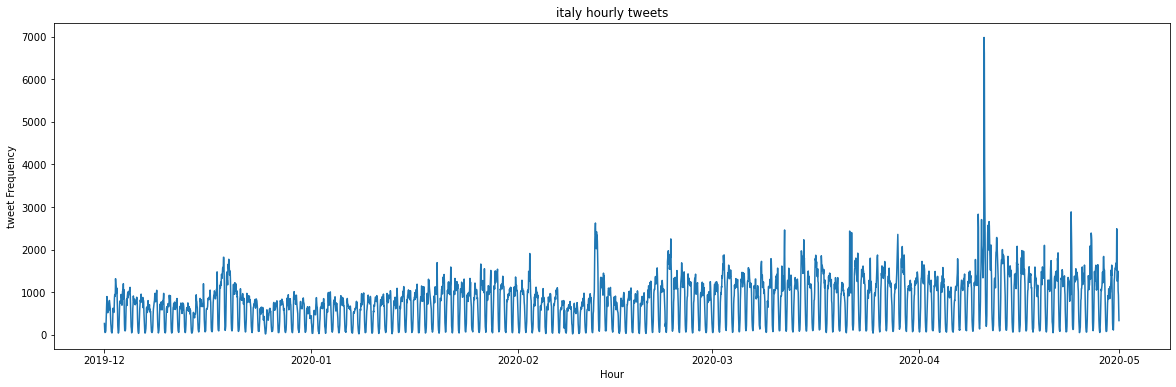

In [17]:
# Country tweet count to read in
country = 'italy'

# Read in tweet_counts as dataframe
country_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\' + country + '_tweet_counts_01122019_01052020.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
country_tweet_counts['date'] = pd.to_datetime(country_tweet_counts['date'])

# Plot hourly tweet counts
date   = country_tweet_counts['date'] 
tweets = country_tweet_counts['total_tweets']

plt.figure(figsize=(20,6))
plt.plot(date, tweets)
plt.title(country + ' hourly tweets')
plt.xlabel('Hour')
plt.ylabel('tweet Frequency')
plt.show()

## Access Tweets

In [6]:
# Function which subsets tweet counts df to only include N day with the most activity
def max_act_days(a,N):
    # Create day variable
    a['day'] = a['date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
    # Create new df to be subsetted later
    x = a
    # Get total tweets for each day and order days from most to least activity
    a = a.groupby('day').sum().sort_values(by='total_tweets',ascending=False)
    # Subset to only include N days with most activity
    a = a.loc[a.index.values.tolist()[0:N],]
    # Subset x to only include max activity days
    x = x[x['day'].astype(str).isin(a.index.values)]
    # Remove day variable
    del x['day']
    # Return results
    return(x)

# Function which calls daily counts for a given search query
def call_tweets (x,y,z):
    # Put together search terms and rules
    rule = gen_rule_payload(x, from_date=y, to_date=z, results_per_call=500)
    # Collect counts
    tweets = collect_results(rule, result_stream_args=premium_search_args)
    return(tweets)

# Function to call tweets as json files
def get_tweets (a,b,c,d,e):
    
    # Obtain the time to call on each day of the study period
    ## This is the hour after the one with the most tweets that meet the search criteria within a 24 hours period.
    
    # Create new 'day' datetime variable which does not include hours of minutes
    a['day'] = a['date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
    
    # Subset the dataframe to only include the hour with most tweets on each day
    max_hour = a.loc[a.groupby('day')['total_tweets'].agg(pd.Series.idxmax)]['date']
    
    # Add an hour to all of these times (Max Hour Plus One) and convert to a list of string variables
    #mhpo = max_hour.apply(lambda x: x + timedelta(hours = 1) ).apply(lambda x: dt2str(x)).tolist()
    
    # Add 30 minutes to all of these times (for the USA's second call) and convert to a list of string variables
    #mhpo = max_hour.apply(lambda x: x + timedelta(minutes = 30) ).apply(lambda x: dt2str(x)).tolist()
    
    # Don't add an hour. Convert to a list of string variables
    mhpo = max_hour.apply(lambda x: dt2str(x)).tolist()
    
    # Identify how many days there are between the start and end date
    #days = (str2dt(end_date) - str2dt(start_date)).days
    days = len(a['day'].unique())
    
    # Create empty list to put tweets in
    tweets = []
    
    for i in range(days):
        # Define the end datetime as the time in the mhpo (Max Hour Plus One) list for a given date
        end   = mhpo[i]
        # Define start time as 72 hours before the end time (arbitrary time period considered sufficient to ensure 500 tweets are collected)
        start = dt2str(str2dt(mhpo[i]) - timedelta(days = 3))
        
        # Creates list of tweets for a given day
        tweets_temp = []
        # Counts are called for search terms
        terms_tweets    = call_tweets((b + e), start, end)
        # Counts are called for accounts
        accounts_tweets = call_tweets((c + e), start, end)
        # Counts are called for hashtags
        hashtags_tweets = call_tweets((d + e), start, end)
        # Compile tweets into 'tweets_temp' lists
        tweets_temp.extend((terms_tweets, accounts_tweets, hashtags_tweets))
        # Append 'tweets_temp' to 'tweets' list
        tweets.append(tweets_temp)
        # Print to report completion
        print(str(i + 1) + ' of ' + str(days) + ' days called.', end="\r")
    
    return(tweets)

In [3]:
# Define tweet search parameters
start_date  = "2019-12-01 00:00"
end_date    = "2020-05-01 00:00"

#### Call UK Tweets

In [109]:
# Read in uk_tweet_counts.csv as dataframe
uk_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\uk_tweet_counts_01122019_01052020.csv').drop(['Unnamed: 0'], axis=1)
#uk_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\uk_tweet_counts_01052020_01112020.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
uk_tweet_counts['date'] = pd.to_datetime(uk_tweet_counts['date'])

In [110]:
# Subset tweet count to only include the 75 days with the most activity
uk_tweet_counts_max_days = max_act_days(uk_tweet_counts,75)

In [111]:
# Call tweets from API
#uk_tweets = get_tweets(uk_tweet_counts_max_days, uk_terms, uk_accounts, uk_hashtags, uk_add_terms)

<ipython-input-108-6422a7934962>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['day'] = a['date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))


In [112]:
# Save tweets as json file
#with open(rp + dp + 'tweets\\uk_tweets_01122019_01052020.json', 'w') as f:
#    json.dump(uk_tweets, f)
#with open(rp + dp + 'tweets\\uk_tweets_01122019_01052020_max.json', 'w') as f:
#    json.dump(uk_tweets, f)
#with open(rp + dp + 'tweets\\uk_tweets_01052020_01112020.json', 'w') as f:
#    json.dump(uk_tweets, f)

#### Call USA Tweets

In [18]:
# Read in usa_tweet_counts.csv as dataframe
#usa_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\usa_tweet_counts_01122019_01052020.csv').drop(['Unnamed: 0'], axis=1)
usa_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\usa_tweet_counts_01052020_01112020.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
usa_tweet_counts['date'] = pd.to_datetime(usa_tweet_counts['date'])

In [20]:
# Call tweets from API
#usa_tweets = get_tweets(usa_tweet_counts, usa_terms, usa_accounts, usa_hashtags, usa_add_terms)

In [21]:
# Save tweets as json file
#with open(rp + dp + 'tweets\\usa_tweets_01122019_01052020_with_retweets.json', 'w') as f:
#    json.dump(usa_tweets, f)
with open(rp + dp + 'tweets\\usa_tweets_01052020_01112020.json', 'w') as f:
    json.dump(usa_tweets, f)

#### Call Spain Tweets

In [ ]:
# Read in usa_tweet_counts.csv as dataframe
spain_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\spain_tweet_counts.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
spain_tweet_counts['date'] = pd.to_datetime(spain_tweet_counts['date'])

In [ ]:
# Call tweets from API
#spain_tweets = get_tweets(spain_tweet_counts, spain_terms, spain_accounts, spain_hashtags, spain_add_terms)

In [ ]:
# Save tweets as json file
#with open(rp + dp + 'tweets\\spain_tweets.json', 'w') as f:
#    json.dump(spain_tweets, f)

#### Call Italy Tweets

In [21]:
# Read in italy_tweet_counts.csv as dataframe
italy_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\italy_tweet_counts_01122019_01052020.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
italy_tweet_counts['date'] = pd.to_datetime(italy_tweet_counts['date'])

In [22]:
# Call tweets from API
#italy_tweets = get_tweets(italy_tweet_counts, italy_terms, italy_accounts, italy_hashtags, italy_add_terms)

In [24]:
# Save tweets as json file
#with open(rp + dp + 'tweets\\italy_tweets.json', 'w') as f:
#    json.dump(italy_tweets, f)

#### Call German Tweets

In [ ]:
# Read in usa_tweet_counts.csv as dataframe
grman_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\grman_tweet_counts.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
grman_tweet_counts['date'] = pd.to_datetime(grman_tweet_counts['date'])

In [ ]:
# Call tweets from API
#grman_tweets = get_tweets(grman_tweet_counts, grman_terms, grman_accounts, grman_hashtags, grman_add_terms)

In [ ]:
# Save tweets as json file
#with open(rp + dp + 'tweets\\grman_tweets.json', 'w') as f:
#    json.dump(grman_tweets, f)

## Reformat Tweets

In [39]:
# Function which extracts only essential information from tweets
def reduce_tweets(tw_list):
    tweets = [] # Create balnk file to read tweets into 
    for tweet in tw_list: # For each tweet
        
        reduced_tweet = { # Store key details
            'created_at': tweet['created_at'], # Time and date of tweet
            'status_id': tweet['id_str'], # Unique ID of Tweet
            'username': tweet['user']['screen_name'], # Username of Twitter profile
            'user_id': tweet['user']['id_str'], # Unique ID for Twtter profile
            'text': tweet['text'] # Store text of tweet (140 characters max)
        }
        
        if 'extended_tweet' in tweet: # If tweet is more than 140 characters (Twitter seperates out old and current tweet lengths)
            reduced_tweet.update({'text':tweet['extended_tweet']['full_text']}) # Store full text (else cut off)
        elif 'retweeted_status' in tweet and 'extended_tweet' in tweet['retweeted_status']: # If a retweet and tweet more than 140 characters
            reduced_tweet.update({'text':tweet['retweeted_status']['extended_tweet']['full_text']}) # Store full text
        else: # Else if neither of previous two options, keep 140 characters text
            reduced_tweet.update({'text':tweet['text']})
            
        if 'derived' in tweet['user']: # If present in the users information
            if 'locations' in tweet['user']['derived']: # Store country
                reduced_tweet.update({'country':tweet['user']['derived']['locations'][0]['country']})
#            else:
#                reduced_tweet.update({}'country':''}) # If not present then store as missing
            if 'region' in tweet['user']['derived']['locations'][0]: # If present in the users information
                reduced_tweet.update({'region':tweet['user']['derived']['locations'][0]['region']}) # Store region
#            else:
#                reduced_tweet.update({'region':''}) # If not present then store as missing
            
        if 'retweeted_status' in tweet: # If a retweet (store as nested within same Tweet)
            reduced_tweet.update({'retweeted_user':{'status_id' : tweet['retweeted_status']['id'], # Store original tweet id
                                                    'user_id' : tweet['retweeted_status']['user']['id_str'], # Store user ID of retweeted user
                                                    'username' : tweet['retweeted_status']['user']['screen_name']}, # Store username
                                  'retweeted_status_id': tweet['retweeted_status']['id_str'], # Store retweeted status_id
                                  'retweet_count':tweet['retweeted_status']['retweet_count']}) # Store retweet count
        else:
            reduced_tweet.update({'retweeted_user': np.nan, # No retweet info
                                  'retweeted_status_id': tweet['id_str'], # Store retweeted status_id
                                  'retweet_count':tweet['retweet_count'] }) # Store retweet count
        
        # Create additional dictionary values (eventially df columns) specifically for quoted tweets
        if 'quoted_status' in tweet: # If current tweet is quoting a separate tweet (store as nested within same Tweet)
            reduced_tweet.update({ # Store key details
                'quoted_created_at': tweet['quoted_status']['created_at'], # Time and date of original
                'quoted_status_id': tweet['quoted_status']['id_str'], # Unique ID of original
                'quoted_username': tweet['quoted_status']['user']['screen_name'], # Username of original Twitter profile
                'quoted_user_id': tweet['quoted_status']['user']['id_str'], # Unique ID for original Twtter profile
                'quoted_text': tweet['quoted_status']['text'], # Store text of original (140 characters max)
                'quoted_country': np.nan, # Location details for quoted tweet not available, so assign NaN to ensure compatibility with non-quoted tweets
                'quoted_region': np.nan, # Location details for quoted tweet not available, so assign NaN to ensure compatibility with non-quoted tweets
                'quoted_retweeted_user': np.nan, # Details of retweets not available, so assign NaN to ensure compatibility with non-quoted tweets
                'quoted_retweeted_status_id': tweet['quoted_status']['id_str'], # Details of retweets not available, so assign NaN to ensure compatibility with non-quoted tweets
                'quoted_retweet_count': tweet['quoted_status']['retweet_count'] }) # Retweet_count of quoted tweet
            
            if 'extended_tweet' in tweet['quoted_status']: # If original text is more than 140 characters (Twitter seperates out old and current tweet lengths)
                reduced_tweet.update({'quoted_text':tweet['quoted_status']['extended_tweet']['full_text']}) # Store full text (else cut off)
            else: # Else keep 140 characters text
                reduced_tweet.update({'quoted_text':tweet['quoted_status']['text']})
        
        tweets.append(reduced_tweet)
        
    return (tweets)

# Function which converts reduced tweets to a dataframe and preps data for vader lexicon
def to_df_vader(x,y,a,b):
    
    # Create copy of original twitter list
    x = x.copy()
    
    # Create list of names for each type of search
    search_type = ["key_terms", "accounts", "hashtags"]
    
    # for loop which extracts data from each 500 tweet search, then converts to df
    for day in range(len(x)): # main loop iterates through each day
        for st in range(len(x[day])): # nested loop iterates through each of search type
            x[day][st] = reduce_tweets(x[day][st]) # Uses reduced_tweets() to extract essential info from tweets
            x[day][st] = pd.DataFrame(x[day][st]) # Converts resulting dictionary to df
            x[day][st]['search_type'] = search_type[st] # Creates 'search_type' column and assigned a tupe from previously creates list
        x[day] = pd.concat(x[day]) # Concatenates tweets from each search type for a given day
    
    # Concatenates tweets from across all days called and resets index
    x = pd.concat(x).reset_index().drop(['index'], axis=1)
    
    # Create list of column names specifically assigned to quoted tweets
    quoted = ['quoted_created_at', 'quoted_status_id', 'quoted_username', 'quoted_user_id', 'quoted_text', 
              'quoted_country', 'quoted_region', 'quoted_retweeted_user', 'quoted_retweeted_status_id', 'quoted_retweet_count']
    
    # Create df for main tweets where these quoted tweet columns have been dropped
    df = x.drop(quoted, axis = 1)
    
    # Assign all rows in this df as not quoted tweets
    df['quoted_tweet'] = False
    
    # Create second df which only includes quoted variables
    quoted_df = x[quoted + ['search_type'] ]
    
    # Drop all NaN rows from quoted_df (rows where no tweet was quoted) as well as duplicates (where same tweet quoted multiple times)
    quoted_df = quoted_df[quoted_df['quoted_created_at'].notna()].drop_duplicates()
     
    # Assign all rows in this df as quoted tweets
    quoted_df['quoted_tweet'] = True
    
    # Change column names to those of the non-quoted df
    quoted_df.columns = list(df.columns)
    
    # Subset to only include tweets which contain at least 1 of the country specific search terms (y)
    quoted_df = quoted_df[quoted_df['text'].str.contains('|'.join(y), case = False)]
    
    # Append dataframes, drop any quoted tweets which have already been captured by the original search, and reset index
    df = df.append(quoted_df).drop_duplicates('status_id', keep='first').reset_index(drop = True)
    
    # Convert 'created_at' to datetime variable
    df['created_at'] = df['created_at'].apply(lambda z: z[4:10] + z[25:30] + z[10:19] )\
                                       .apply(lambda z: datetime.strptime(z, '%b %d %Y %H:%M:%S') )
    
    # Use datetime variable to subset tweets to include only those posted within the study period (some quoted tweets were posted as early at 2013)
    # Order by time posted then reset index
    df = df[(df['created_at'] >= a) & (df['created_at'] < b)].sort_values(by='created_at').reset_index(drop = True)
    
    # Drop duplicated retweets (i.e. only keep of retweet of each original tweet not captured in the dataset, 
    # unless the original tweet is captured, in which case remove all retweets of it)
    df = df.drop_duplicates('retweeted_status_id', keep='first').reset_index(drop = True)
    # Delete retweeted_status_id
    del df['retweeted_status_id']
    
    # Create column for vader input
    df['VADER_text'] = df['text'].apply(lambda x: re.sub('@(.*?) ', '@anonymous ', x)) # Change accounts for '@anonymous'
    # Remove urls and line breaks
    df['VADER_text'] = df['VADER_text'].apply(lambda x: re.sub(r"http\S+", "http://url_removed", str(x)) )\
                                       .apply(lambda x: re.sub('http(.*?) ', "http://url_removed", str(x)) )\
                                       .apply(lambda x: re.sub('\n', ' ', str(x)) )
    
    # Subset to remove tweets dicussing bird or data migration
    nature_and_data = ['bird', 'ornithology', '#wildlife', '#deer', '#buck', '#antlers', '#nature', 
                       'github', 'Azure', 'Microsoft', 'Ubuntu', 'Python', 'SQL', 'cloud', 'bigdata', 'big data', 'virtual machine', 'DevOps']
    # Define phrases prevent tweets from being falsely labeled as noise
    exclude_words  = ['cloud cuckoo land', 'two birds one stone', 'two birds with one stone', '@Nigel_Farage', 'NigelFarage', 'Nigel Farage', 'refugee']
    # Remove tweets which contain 'nature_and_data', but not 'exclude_words'
    df = df[~df['text'].replace(exclude_words,'', regex=True)
                       .str.contains('|'.join(nature_and_data), case = False)].reset_index(drop = True)
    
    # Return final dataframe
    return(df)

# Convert terms such as OMG to Oh My God - I have also included RT as retweet or HT as hattip
# Code From: https://medium.com/nerd-stuff/python-script-to-turn-text-message-abbreviations-into-actual-phrases-d5db6f489222
def translator(user_string):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "./slang.txt"

        # File Access mode [Read Mode]
        with open(fileName, "r") as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9]+', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
                    user_string[j] = row[1]
            myCSVfile.close()
        j = j + 1
    return ' '.join(user_string)

# Function which replaces all hashtags in a text with their constituent words
def expand_hashtags(x):
    # Finds all hashtags and inserts into list
    hts = re.findall('#(.*?) ',x) 
    # Breaks hashtags into their constituent words and convert all characters to lower case
    expanded_hts = list(map(lambda y: " ".join([a for a in re.split('([A-Z][a-z]+)', y) if a]).lower(), hts))
    # for loop which replaces hashtags with their constituent words
    for i in range(len(expanded_hts)):
        x = re.sub('#(.*?) ', expanded_hts[i] + ' ', x, 1)
    return(x)

# Function which converts emojis to single sentence description
def convert_emojis(x):
    # If string contains emojis
    if len(demoji.findall(x)) > 0:
        # Extract all emojis and convert to dictionary (with emojis as keys and descriptions as values)
        emojis = demoji.findall(x)
        # for loop which replaces each emoji with description, with 1st letter capitalised and a full stop
        for i in range(len(emojis)):
            x = re.sub(list(emojis)[i], list(emojis.values())[i].capitalize() + '.', x)
    return(x)

# Function which prepares text for topic analysis
def clean_tweet_text(df):
    
    ## Convert full text to string ##
    
    # Some tweets are classified by Python as 'floats' so need to convert to string for cleaning process
    print('Converting full text to string...')
    try: # Check if tweets have been translated
        df['translated_text']
    except: # If not, clean VADER_text
        df['lexicon_text'] = df['VADER_text'].astype(str)
    else: # If yes, clean translated_text
        df['lexicon_text'] = df['translated_text'].astype(str)
    
    ## Remove retweet prefix ##
    
    # Create a new column which removes retweets (except in cases where we do not have the retweet, in which case the first retweet chronologically is kept)
    print('Removing retweet prefix...')
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub('RT (.*?): ', '', x)) # Remove text prefixed to some retweets so tweets and retweets can be directly compared by text
    
    ## Replace abbreviations ##
    
    # Apply translator function to text 
    #print('Replacing abbreviations...')
    #import time
    #start_time = time.time()
    #df['lexicon_text'] = df['lexicon_text'].apply(lambda x:  translator(x)  )
    #print("--- Run Time: %s seconds ---" % (time.time() - start_time))
    
    ## Expand hashtags ##
    
    # Replace hashtags with constituent words
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: expand_hashtags(x) )
    
    ## Remove accounts and urls  ##
    
    # Remove @'s but keep the account name. This is so the account name is (hopefully) interpreted by coreNLP as an person, 
    # thereby maintaining the integrity of the sentence structure to improve sentiment score.
    print('Removing accounts and urls...')
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub("RT @anonymous", "", str(x))  )
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub("http: // url_removed", "", str(x))  )
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub("http://url_removed", "", str(x))  )
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub("@anonymous", "", str(x))  )
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub("@", "", str(x))  )
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub("&quot;", "", str(x))  )
    
    ## Replace &amp; with and ##
    
    #print('Replacing \'&amp;\' with \'and\'...')
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub("&amp;", "and", str(x))  )
    
    ## Remove hyperlinks ##
    
    # Remove hyperlinks at the end and embeddeded in the middle of the string
    #print('Removing hyperlinks...')
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub(r"http\S+", "", str(x)) )\
                                           .apply(lambda x: re.sub('http(.*?) ', "", str(x)) )
    
    ## Replace emojis ##
    
    # Replaces emojis with a single sentence description
    #print('Replacing emojis...')
    #df['lexicon_text'] = df['lexicon_text'].apply(lambda x: convert_emojis(str(x)) )
    
    ## Remove tweets related to bird, animal or data migration ##
    
    #print('Removing tweets related to bird, animal or data migration...')
    # Define words associated with noise topics
    
    
    ## Remove \n's and spaces before punctuation ##
    
    print('Removing \n\'s and spaces before punctuation...')
    # Replace line breaks with spaces and remove spaces before punctuation
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub('\n',' ',str(x)) )\
                                           .apply(lambda x: re.sub(r'\s([?.!"](?:\s|$))', r'\1', str(x)) )
    
    ## Remove emoji descriptions with misleading discriptions ## 
    
    # Remove description of 'see/hear/speak no evil monkey' (one-off edit due to observations of emoji descriptions)
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: re.sub(r'-no-evil monkey',' no monkey emoji',str(x)) )
    
    ## Remove punctuation ##
    
    # We are not interested in punctuation for analyses so replace them with a space
    print('Removing punctuation...')
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x : re.sub(r'[^a-zA-Z ]',' ',str(x)))
    # If want to include numbers use re.sub(r'[^a-zA-Z0-9 ]'
    
    ## Convert all words to lower case ##

    # To normalise comparisons else Love and love are treated seperately (for upper case swicth to 'word.upper())
    print('Converting all words to lower case...')
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: ' '.join( [ word.lower() for word in x.split() ] ) )
    
    ## Remove stop words ##
    
    # Remove common words such as 'a', 'the', 'on' that do not contribute to the meaning of texts through providing unncessary information
    print('Removing stop words...')
    from nltk.corpus import stopwords
    stop = stopwords.words("english") # Define stopwords
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # Remove from tweet 
    
    ## Normalising language ##
    
    # Lemmatization
    # Convert terms to their root dictionary form (or lemma) e.g. runs, running and ran are each forms of run
    # Pros: greater context to root terms as uses valid words
    # Cons: requires greater memory to run, does not always get to root word
    
    # We will go with Lemmatization as more useful in interpretation of words
    
    # nltk.download() # To install WordNet corpora
    print('Normalising language...')
    from nltk.stem.wordnet import WordNetLemmatizer
    lmtzr = WordNetLemmatizer()
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x.split() ]))
    
    print('Done.')
    
    # Return reformated dataframe
    return(df)

### Reformat UK Tweets

##### Extract key info and format VADER text

In [58]:
# Read in tweets from json file
#with open(rp + dp + 'tweets\\uk_tweets_01122019_01052020.json') as f:
#    uk_tweets_01122019_01052020 = json.load(f)
with open(rp + dp + 'tweets\\uk_tweets_01122019_01052020_max.json') as f:
    uk_tweets_01122019_01052020_max = json.load(f)
#with open(rp + dp + 'tweets\\uk_tweets_01052020_01112020.json') as f:
#    uk_tweets_01052020_01112020 = json.load(f)

In [ ]:
#uk_tweets_01122019_01052020     = to_df_vader(uk_tweets_01122019_01052020, uk_search_terms, "2019-12-01", "2020-05-01")
uk_tweets_01122019_01052020_max = to_df_vader(uk_tweets_01122019_01052020_max, uk_search_terms, "2019-12-01", "2020-05-01")
#uk_tweets_01052020_01112020     = to_df_vader(uk_tweets_01052020_01112020, uk_search_terms, "2020-05-01", "2020-11-01")

##### Combine searches

In [7]:
# Read in formatted tweets as dataframe
uk_tweets_01122019_01052020 = pd.read_csv(rp + dp + 'tweets\\uk_tweets_01122019_01052020_VADER_removed_dpl_RT_and_status_id_only.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
uk_tweets_01122019_01052020['created_at'] = pd.to_datetime(uk_tweets_01122019_01052020['created_at'])

# Read in formatted tweets as dataframe
uk_tweets_01122019_01052020_max = pd.read_csv(rp + dp + 'tweets\\uk_tweets_01122019_01052020_VADER_max.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
uk_tweets_01122019_01052020_max['created_at'] = pd.to_datetime(uk_tweets_01122019_01052020_max['created_at'])

# Read in formatted tweets as dataframe
#uk_tweets_01052020_01112020 = pd.read_csv(rp + dp + 'tweets\\uk_tweets_01052020_01112020_VADER.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
#uk_tweets_01052020_01112020['created_at'] = pd.to_datetime(uk_tweets_01052020_01112020['created_at'])

In [20]:
# Append dataframes, sort tweets chronologically, drop any tweets which have already been captured by the non-retweet search, and reset index
uk_tweets_01122019_01052020 = pd.concat([uk_tweets_01122019_01052020, uk_tweets_01122019_01052020_max]).sort_values(by='created_at').drop_duplicates('status_id', keep='first').reset_index(drop = True)
#uk_tweets_01122019_01112020 = pd.concat([uk_tweets_01122019_01052020, uk_tweets_01052020_01112020]).sort_values(by='created_at').drop_duplicates('status_id', keep='first').reset_index(drop = True)

##### Clean data for topic modelling

In [22]:
uk_tweets_01122019_01052020 = clean_tweet_text(uk_tweets_01122019_01052020)
#uk_tweets_01122019_01112020 = clean_tweet_text(uk_tweets_01122019_01112020)

Converting full text to string...
Removing retweet prefix...
Removing accounts and urls...
Removing 
's and spaces before punctuation...
Removing punctuation...
Converting all words to lower case...
Removing stop words...
Normalising language...
Done.


In [23]:
# Save tweets as csv
#uk_tweets_01122019_01052020.to_csv(rp + dp + 'tweets\\uk_tweets_01122019_01052020_VADER_removed_dpl_RT_and_status_id_only.csv')
#uk_tweets_01122019_01052020_max.to_csv(rp + dp + 'tweets\\uk_tweets_01122019_01052020_VADER_max.csv')
#uk_tweets_01052020_01112020.to_csv(rp + dp + 'tweets\\uk_tweets_01052020_01112020_VADER.csv')
uk_tweets_01122019_01052020.to_csv(rp + dp + 'tweets\\uk_tweets_01122019_01052020_VL.csv')
#uk_tweets_01122019_01112020.to_csv(rp + dp + 'tweets\\uk_tweets_01122020_01112020_VL.csv')

### Reformat USA tweets

##### Extract key info and format VADER text

In [79]:
# Read in tweets from json file
#with open(rp + dp + 'tweets\\usa_tweets_01122019_01052020.json') as f:
#    usa_tweets_01122019_0105020 = json.load(f)
with open(rp + dp + 'tweets\\usa_tweets_01122019_01052020_with_retweets.json') as f:
    usa_tweets_01122019_0105020_wrtwts = json.load(f)
#with open(rp + dp + 'tweets\\usa_tweets_01052020_01112020.json') as f:
#    usa_tweets_01052020_01112020 = json.load(f)

In [28]:
# Reformat tweets
#usa_tweets_01122019_0105020 = to_df_vader(usa_tweets_01122019_0105020, usa_search_terms, "2019-12-01", "2020-05-01")
usa_tweets_01122019_0105020_wrtwts = to_df_vader(usa_tweets_01122019_0105020_wrtwts, usa_search_terms, "2019-12-01", "2020-05-01")
#usa_tweets_01052020_01112020 = to_df_vader(usa_tweets_01052020_01112020, usa_search_terms, "2020-05-01", "2020-11-01")

In [29]:
# Save tweets as csv
#usa_tweets_01122019_0105020.to_csv(rp + dp + 'tweets\\usa_tweets_01122019_01052020_VADER.csv')
usa_tweets_01122019_0105020_wrtwts.to_csv(rp + dp + 'tweets\\usa_tweets_01122019_01052020_VADER_with_retweets.csv')
#usa_tweets_01052020_01112020.to_csv(rp + dp + 'tweets\\usa_tweets_01052020_01112020_VADER.csv')

##### Combine searches

In [30]:
# Read in formatted tweets as dataframe
usa_tweets_01122019_01052020 = pd.read_csv(rp + dp + 'tweets\\usa_tweets_01122019_01052020_VADER.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
usa_tweets_01122019_01052020['created_at'] = pd.to_datetime(usa_tweets_01122019_01052020['created_at'])

# Read in formatted tweets as dataframe
usa_tweets_01122019_01052020_wrtwts = pd.read_csv(rp + dp + 'tweets\\usa_tweets_01122019_01052020_VADER_with_retweets.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
usa_tweets_01122019_01052020_wrtwts['created_at'] = pd.to_datetime(usa_tweets_01122019_01052020_wrtwts['created_at'])

# Read in formatted tweets as dataframe
#usa_tweets_01052020_01112020 = pd.read_csv(rp + dp + 'tweets\\usa_tweets_01052020_01112020_VADER.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
#usa_tweets_01052020_01112020['created_at'] = pd.to_datetime(usa_tweets_01052020_01112020['created_at'])

In [31]:
# Create column which records which call they have come from
usa_tweets_01122019_01052020['wrtwts_call'] = False
usa_tweets_01122019_01052020_wrtwts['wrtwts_call'] = True
#usa_tweets_01052020_01112020['wrtwts_call'] = True

# Append dataframes, sort tweets chronologically, drop any tweets which have already been captured by the non-retweet search, and reset index
usa_tweets_01122019_01052020 = pd.concat([usa_tweets_01122019_01052020, usa_tweets_01122019_01052020_wrtwts]).sort_values(by='created_at').drop_duplicates('status_id', keep='first').reset_index(drop = True)
#usa_tweets_01122019_01112020 = pd.concat([usa_tweets_01122019_01052020, usa_tweets_01122019_01052020_wrtwts, usa_tweets_01052020_01112020]).sort_values(by='created_at').drop_duplicates('status_id', keep='first').reset_index(drop = True)

##### Clean data for topic modelling

In [32]:
usa_tweets_01122019_01052020 = clean_tweet_text(usa_tweets_01122019_01052020)
#usa_tweets_01122019_01112020 = clean_tweet_text(usa_tweets_01122019_01112020)

Converting full text to string...
Removing retweet prefix...
Removing accounts and urls...
Removing 
's and spaces before punctuation...
Removing punctuation...
Converting all words to lower case...
Removing stop words...
Normalising language...
Done.


##### Save output

In [34]:
# Save tweets as csv
usa_tweets_01122019_01052020.to_csv(rp + dp + 'tweets\\usa_tweets_01122019_01052020_VL.csv')
#usa_tweets_01122019_01112020.to_csv(rp + dp + 'tweets\\usa_tweets_01122019_01112020_VL.csv')

### Reformat Spain tweets

##### Extract key info and format VADER text

In [35]:
# Read in tweets from json file
with open(rp + dp + 'tweets\\spain_tweets_01122019_01052020.json') as f:
    spain_tweets = json.load(f)

In [36]:
# Converts tweets to manageable dataframe
spain_tweets = to_df_vader(spain_tweets, spain_search_terms, "2019-12-01", "2020-05-01")

##### Clean data for topic modelling

In [107]:
# Read in formatted tweets as dataframe
spain_tweets = pd.read_csv(rp + dp + 'tweets\\spain_tweets_01122019_01052020_VADER_translated.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
spain_tweets['created_at'] = pd.to_datetime(spain_tweets['created_at'])

In [37]:
spain_tweets = clean_tweet_text(spain_tweets)

Converting full text to string...
Removing retweet prefix...
Removing accounts and urls...
Removing 
's and spaces before punctuation...
Removing punctuation...
Converting all words to lower case...
Removing stop words...
Normalising language...
Done.


##### Save output

In [109]:
# Save tweets as csv
spain_tweets.to_csv(rp + dp + 'tweets\\spain_tweets_01122019_01052020_VTL.csv')

### Reformat Italy tweets

##### Extract key info and format VADER text

In [ ]:
# Read in tweets from json file
with open(rp + dp + 'tweets\\italy_tweets_01122019_01052020.json') as f:
    italy_tweets = json.load(f)

In [27]:
# Converts tweets to manageable dataframe
italy_tweets = to_df_vader(italy_tweets, italy_search_terms, "2019-12-01", "2020-05-01")

##### Clean data for topic modelling

In [110]:
# Read in formatted tweets as dataframe
italy_tweets = pd.read_csv(rp + dp + 'tweets\\italy_tweets_01122019_01052020_VADER_translated.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
italy_tweets['created_at'] = pd.to_datetime(italy_tweets['created_at'])

In [111]:
italy_tweets = clean_tweet_text(italy_tweets)

Converting full text to string...
Removing retweet prefix...
Removing accounts and urls...
Replacing '&amp;' with 'and'...
Removing hyperlinks...
Removing 
's and spaces before punctuation...
Removing punctuation...
Converting all words to lower case...
Removing stop words...
Normalising language...
Done.


##### Save output

In [112]:
# Save tweets as csv
italy_tweets.to_csv(rp + dp + 'tweets\\italy_tweets_01122019_01052020_VTL.csv')

### Reformat German tweets

##### Extract key info and format VADER text

In [18]:
# Read in tweets from json file
with open(rp + dp + 'tweets\\grman_tweets_01122019_01052020.json') as f:
    grman_tweets = json.load(f)

In [19]:
# Converts tweets to manageable dataframe
grman_tweets = to_df_vader(grman_tweets, grman_search_terms, "2019-12-01", "2020-05-01")

##### Clean data for topic modelling

In [113]:
# Read in formatted tweets as dataframe
grman_tweets = pd.read_csv(rp + dp + 'tweets\\grman_tweets_01122019_01052020_VADER_translated.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
grman_tweets['created_at'] = pd.to_datetime(grman_tweets['created_at'])

In [114]:
grman_tweets = clean_tweet_text(grman_tweets)

Converting full text to string...
Removing retweet prefix...
Removing accounts and urls...
Replacing '&amp;' with 'and'...
Removing hyperlinks...
Removing 
's and spaces before punctuation...
Removing punctuation...
Converting all words to lower case...
Removing stop words...
Normalising language...
Done.


##### Save output

In [97]:
# Save tweets as csv
grman_tweets.to_csv(rp + dp + 'tweets\\grman_tweets_01122019_01052020_VTL.csv')

## Get Proportion of Retweets

In [ ]:
# Function which converts reduced tweets to a dataframe
def to_df_prop_rt(x,y,a,b):
    
    # Create copy of original twitter list
    x = x.copy()
    
    # Create list of names for each type of search
    search_type = ["key_terms", "accounts", "hashtags"]
    
    # for loop which extracts data from each 500 tweet search, then converts to df
    for day in range(len(x)): # main loop iterates through each day
        for st in range(len(x[day])): # nested loop iterates through each of search type
            x[day][st] = reduce_tweets(x[day][st]) # Uses reduced_tweets() to extract essential info from tweets
            x[day][st] = pd.DataFrame(x[day][st]) # Converts resulting dictionary to df
            x[day][st]['search_type'] = search_type[st] # Creates 'search_type' column and assigned a tupe from previously creates list
        x[day] = pd.concat(x[day]) # Concatenates tweets from each search type for a given day
    
    # Concatenates tweets from across all days called and resets index
    df = pd.concat(x).reset_index().drop(['index'], axis=1)
    
    # Convert 'created_at' to datetime variable
    df['created_at'] = df['created_at'].apply(lambda z: z[4:10] + z[25:30] + z[10:19] )\
                                       .apply(lambda z: datetime.strptime(z, '%b %d %Y %H:%M:%S') )
    
    # Use datetime variable to subset tweets to include only those posted within the study period (some quoted tweets were posted as early at 2013)
    # Order by time posted then reset index
    df = df[(df['created_at'] >= a) & (df['created_at'] < b)].sort_values(by='created_at').reset_index(drop = True)
    
    # Return final dataframe
    return(df)

def get_prop_rt(x,y,z):
    
    x['hour'] = x['created_at'].apply(lambda z: datetime.strptime(str(z)[0:13], '%Y-%m-%d %H') )
    
    df = x[x['search_type'] == z].reset_index(drop=True)
    
    df = df.drop_duplicates('status_id', keep='first').reset_index(drop = True)
    
    df = df.groupby('hour')['hour'].agg(lambda x: x.shape[0])\
                                   .sort_values(ascending=False)
    
    df = pd.concat([pd.DataFrame(df.index.values), pd.DataFrame(df).reset_index(drop = True)], axis=1, ignore_index=True)
    
    df.columns = ['hour','ntwts']
    
    df = df.sort_values(by='hour')
    
    if z == 'key_terms':
        y = y[['date','terms_tweets']].copy()
    elif z == 'accounts':
        y = y[['date','accounts_tweets']].copy()
    else:
        y = y[['date','hashtags_tweets']].copy()
    
    y.columns = ['hour','tweet_count']
    
    dfsub = df[df['ntwts'] < 500]
    
    dfsub = dfsub.merge(y, how='right', on='hour').sort_values('hour').reset_index(drop = True)
    
    for row in range(dfsub.shape[0]-1):
        if np.isnan(dfsub.loc[row + 1,'ntwts']):
            dfsub.loc[row,'ntwts'] = np.nan
    
    dfsub['ntwts'] = dfsub['ntwts'].apply(lambda x: 0 if np.isnan(x) else x )
    
    dfsub['prop_rt'] = dfsub['ntwts'] / dfsub['tweet_count']
    
    return(dfsub)

def get_prop_rt_df(x,y):
    kt = get_prop_rt(x,y,"key_terms")
    ac = get_prop_rt(x,y,"accounts")
    ht = get_prop_rt(x,y,"hashtags")
    df = pd.concat([kt, ac[['ntwts','tweet_count','prop_rt']],
                        ht[['ntwts','tweet_count','prop_rt']]], axis = 1)
    df.columns = ['hours', 'kt_ntwts','kt_tweet_count','kt_prop_rt',
                           'ac_ntwts','ac_tweet_count','ac_prop_rt', 
                           'ht_ntwts','ht_tweet_count','ht_prop_rt']
    return(df)
    
def save_prop_rt(x,y):
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(9, figsize=(20,28))
    
    fig.suptitle('Summary of Tweet Count verses Tweets Captured in ' + y, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    ax1.plot(x['hours'], x['kt_tweet_count'], color='dimgrey')
    ax1.set_title('Key Term Search', fontsize=14)
    ax1.set_ylabel('Tweet Count')
    ax2.plot(x['hours'], x['kt_ntwts'], color='dimgrey')
    ax2.set_ylabel('Tweets Captured')
    ax3.plot(x['hours'], x['kt_prop_rt'], color='dimgrey')
    ax3.set_ylabel('Proportion of Tweet Count Captured')
    
    ax4.plot(x['hours'], x['ac_tweet_count'], color='seagreen')
    ax4.set_title('Account Search', fontsize=14)
    ax4.set_ylabel('Tweet Count')
    ax5.plot(x['hours'], x['ac_ntwts'], color='seagreen')
    ax5.set_ylabel('Tweets Captured')
    ax6.plot(x['hours'], x['ac_prop_rt'], color='seagreen')
    ax6.set_ylabel('Proportion of Tweet Count Captured')
    
    ax7.plot(x['hours'], x['ht_tweet_count'], color='steelblue')
    ax7.set_title('Hashtag Search', fontsize=14)
    ax7.set_ylabel('Tweet Count')
    ax8.plot(x['hours'], x['ht_ntwts'], color='steelblue')
    ax8.set_ylabel('Tweets Captured')
    ax9.plot(x['hours'], x['ht_prop_rt'], color='steelblue')
    ax9.set_ylabel('Proportion of Tweet Count Captured')
    
    plt.savefig(rp + 'fig\\' + y + '_prop_rt_plot.png')

#### Get USA Proportion of Retweets

In [ ]:
# Read in tweets from json file
with open(rp + dp + 'tweets\\usa_tweets_01122019_01052020.json') as f:
    usa_tweets = json.load(f)

In [ ]:
# Read in usa_tweet_counts.csv as dataframe
usa_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\usa_tweet_counts_01122019_01052020.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
usa_tweet_counts['date'] = pd.to_datetime(usa_tweet_counts['date'])

In [ ]:
usa_test = to_df_prop_rt(usa_tweets, usa_search_terms, "2019-12-01", "2020-05-01")
usa_prop_rt = get_prop_rt_df(usa_test,usa_tweet_counts)
save_prop_rt(usa_prop_rt,'usa')

#### Get Spain Proportion of Retweets

In [ ]:
# Read in tweets from json file
with open(rp + dp + 'tweets\\spain_tweets_01122019_01052020.json') as f:
    spain_tweets = json.load(f)

In [ ]:
# Read in usa_tweet_counts.csv as dataframe
spain_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\spain_tweet_counts_01122019_01052020.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
spain_tweet_counts['date'] = pd.to_datetime(spain_tweet_counts['date'])

In [ ]:
spain_test = to_df_prop_rt(spain_tweets, spain_search_terms, "2019-12-01", "2020-05-01")
spain_prop_rt = get_prop_rt_df(spain_test,spain_tweet_counts)
save_prop_rt(spain_prop_rt,'spain')

#### Get German Proportion of Retweets

In [ ]:
# Read in tweets from json file
with open(rp + dp + 'tweets\\grman_tweets_01122019_01052020.json') as f:
    grman_tweets = json.load(f)

In [ ]:
# Read in usa_tweet_counts.csv as dataframe
grman_tweet_counts = pd.read_csv(rp + dp + 'tweet_counts\\grman_tweet_counts_01122019_01052020.csv').drop(['Unnamed: 0'], axis=1)
# Convert date variable from str to datetime
grman_tweet_counts['date'] = pd.to_datetime(grman_tweet_counts['date'])

In [ ]:
grman_test = to_df_prop_rt(grman_tweets, grman_search_terms, "2019-12-01", "2020-05-01")
grman_prop_rt = get_prop_rt_df(grman_test,grman_tweet_counts)
save_prop_rt(grman_prop_rt,'grman')

## Get Proportion Covid Related

#### Read in data

In [39]:
def import_csv(x):
    # Read in tweets as dataframe
    x = pd.read_csv(rp + dp + 'tweets\\' + x + '.csv').drop(['Unnamed: 0'], axis=1)
    # Convert date variable from str to datetime
    x['created_at'] = pd.to_datetime(x['created_at'])
    # Return df
    return x

# Read in data
uk_tweets    = import_csv('uk_tweets_01122019_01052020_VL')
usa_tweets   = import_csv('usa_tweets_01122019_01052020_VL')
#spain_tweets = import_csv('spain_tweets_01122019_01052020_VTL')
#italy_tweets = import_csv('italy_tweets_01122019_01052020_VTL')
#grman_tweets = import_csv('grman_tweets_01122019_01052020_VTL')

#### Scrape COVID Terms from Twitter's compiled list

In [40]:
import requests
import random
from bs4 import BeautifulSoup as bs
from itertools import cycle
import traceback
import re

# Function to remove html tags
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

# Define url where covid terms are listed
url = "https://developer.twitter.com/en/docs/labs/covid19-stream/filtering-rules"
# Get the HTTP response and construct soup object
soup = bs(requests.get(url).content, "html.parser")
# Extract all terms
html_terms = soup.find("table").find_all("p")
# Create empty list
covid_terms = []
# For loop which appends terms to empty list
for term in html_terms:
    term = cleanhtml(str(term))
    covid_terms.append(term)

#### Determine which tweets mention COVID

In [41]:
# Function which finds tweets which contain covid terms
def assign_covid_tweets(df):
    # Create variable to record whether tweet contains covid term. Default to False
    df['cvd_twt'] = False
    # Create subset dataframe of all tweets which contain covid terms
    covid_df = df[df['text'].str.contains('|'.join(covid_terms), case = False)]
    # Assign 'cvd_twt' in the main dataframe as True for these tweets 
    df.loc[covid_df.index.values.tolist(),'cvd_twt'] = True
    # Return results
    return df

# Assign covid tweets
uk_tweets    = assign_covid_tweets(uk_tweets)
usa_tweets   = assign_covid_tweets(usa_tweets)
#spain_tweets = assign_covid_tweets(spain_tweets)
#italy_tweets = assign_covid_tweets(italy_tweets)
#grman_tweets = assign_covid_tweets(grman_tweets)

#### Save outputs

In [42]:
# Save tweets as csv
uk_tweets.to_csv(rp + dp + 'tweets\\uk_tweets_01122019_01052020_VLC.csv')
usa_tweets.to_csv(rp + dp + 'tweets\\usa_tweets_01122019_01052020_VLC.csv')
#spain_tweets.to_csv(rp + dp + 'tweets\\spain_tweets_01122019_01052020_VTLC.csv')
#italy_tweets.to_csv(rp + dp + 'tweets\\italy_tweets_01122019_01052020_VTLC.csv')
#grman_tweets.to_csv(rp + dp + 'tweets\\grman_tweets_01122019_01052020_VTLC.csv')

In [20]:
uk_tweets    = pd.read_csv(rp + dp + 'tweets\\uk_tweets_01122019_01052020_VLC.csv').drop(['Unnamed: 0'], axis=1)
usa_tweets   = pd.read_csv(rp + dp + 'tweets\\usa_tweets_01122019_01052020_VLC.csv').drop(['Unnamed: 0'], axis=1)
spain_tweets = pd.read_csv(rp + dp + 'tweets\\spain_tweets_01122019_01052020_VTLC.csv').drop(['Unnamed: 0'], axis=1)
italy_tweets = pd.read_csv(rp + dp + 'tweets\\italy_tweets_01122019_01052020_VTLC.csv').drop(['Unnamed: 0'], axis=1)
grman_tweets = pd.read_csv(rp + dp + 'tweets\\grman_tweets_01122019_01052020_VTLC.csv').drop(['Unnamed: 0'], axis=1)

## Save Tweet IDs

In [91]:
# Function which converts reduced tweets to a dataframe and preps data for vader lexicon
def to_df(x):
    
    # Create copy of original twitter list
    x = x.copy()
    
    # Create list of names for each type of search
    search_type = ["key_terms", "accounts", "hashtags"]
    
    # for loop which extracts data from each 500 tweet search, then converts to df
    for day in range(len(x)): # main loop iterates through each day
        for st in range(len(x[day])): # nested loop iterates through each of search type
            x[day][st] = reduce_tweets(x[day][st]) # Uses reduced_tweets() to extract essential info from tweets
            x[day][st] = pd.DataFrame(x[day][st]) # Converts resulting dictionary to df
            x[day][st]['search_type'] = search_type[st] # Creates 'search_type' column and assigned a tupe from previously creates list
        x[day] = pd.concat(x[day]) # Concatenates tweets from each search type for a given day
    
    # Concatenates tweets from across all days called and resets index
    x = pd.concat(x).reset_index().drop(['index'], axis=1)
    
    x = x['status_id'].tolist()
    
    return(x)

### Save UK Tweet IDs

In [96]:
# Read in tweets from json file
#with open(rp + dp + 'tweets\\uk_tweets_01122019_01052020.json') as f:
#    uk_tweets_01122019_01052020 = json.load(f)
with open(rp + dp + 'tweets\\uk_tweets_01122019_01052020_max.json') as f:
    uk_tweets_01122019_01052020_max = json.load(f)

In [97]:
#uk_tweet_ids_01122019_01052020     = to_df(uk_tweets_01122019_01052020)
uk_tweet_ids_01122019_01052020_max = to_df(uk_tweets_01122019_01052020_max)

In [98]:
#with open(rp + dp + "tweets\\uk_tweet_ids_01122019_01052020_1.txt", "w") as fp:
#    json.dump(uk_tweet_ids_01122019_01052020, fp)
with open(rp + dp + "tweets\\uk_tweet_ids_01122019_01052020_2.txt", "w") as fp:
    json.dump(uk_tweet_ids_01122019_01052020_max, fp)

### Save USA Tweet IDs

In [114]:
# Read in tweets from json file
#with open(rp + dp + 'tweets\\usa_tweets_01122019_01052020.json') as f:
#    usa_tweets_01122019_01052020 = json.load(f)
with open(rp + dp + 'tweets\\usa_tweets_01122019_01052020_with_retweets.json') as f:
    usa_tweets_01122019_01052020_wrtwts = json.load(f)

In [115]:
#usa_tweet_ids_01122019_01052020        = to_df(usa_tweets_01122019_01052020)
usa_tweet_ids_01122019_01052020_wrtwts = to_df(usa_tweets_01122019_01052020_wrtwts)

In [116]:
#with open(rp + dp + "tweets\\usa_tweet_ids_01122019_01052020_1.txt", "w") as fp:
#    json.dump(usa_tweet_ids_01122019_01052020, fp)
with open(rp + dp + "tweets\\usa_tweet_ids_01122019_01052020_2.txt", "w") as fp:
    json.dump(usa_tweet_ids_01122019_01052020_wrtwts, fp)

### Save Spain Tweet IDs

In [99]:
# Read in tweets from json file
with open(rp + dp + 'tweets\\spain_tweets_01122019_01052020.json') as f:
    spain_tweets_01122019_01052020 = json.load(f)

In [102]:
spain_tweet_ids_01122019_01052020 = to_df(spain_tweets_01122019_01052020)

In [103]:
with open(rp + dp + "tweets\\spain_tweet_ids_01122019_01052020.txt", "w") as fp:
    json.dump(spain_tweet_ids_01122019_01052020, fp)

### Save Italy Tweet IDs

In [118]:
# Read in tweets from json file
with open(rp + dp + 'tweets\\italy_tweets_01122019_01052020.json') as f:
    italy_tweets_01122019_01052020 = json.load(f)

In [119]:
italy_tweet_ids_01122019_01052020 = to_df(italy_tweets_01122019_01052020)

In [120]:
with open(rp + dp + "tweets\\italy_tweet_ids_01122019_01052020.txt", "w") as fp:
    json.dump(italy_tweet_ids_01122019_01052020, fp)

### Save Germany Tweet IDs

In [122]:
# Read in tweets from json file
with open(rp + dp + 'tweets\\grman_tweets_01122019_01052020.json') as f:
    grman_tweets_01122019_01052020 = json.load(f)

In [123]:
grman_tweet_ids_01122019_01052020 = to_df(grman_tweets_01122019_01052020)

In [124]:
with open(rp + dp + "tweets\\grman_tweet_ids_01122019_01052020.txt", "w") as fp:
    json.dump(grman_tweet_ids_01122019_01052020, fp)

# Misc

#### Retired Code

In [ ]:
## Code used to clean tweet text before we decided to use the VADER lexicon

# Function which converts reduced tweets to a dataframe
def to_df(x,y,a,b):
    
    # Create list of names for each type of search
    search_type = ["key_terms", "accounts", "hashtags"]
    
    # for loop which extracts data from each 500 tweet search, then converts to df
    for day in range(len(x)): # main loop iterates through each day
        for st in range(len(x[day])): # nested loop iterates through each of search type
            x[day][st] = reduce_tweets(x[day][st]) # Uses reduced_tweets() to extract essential info from tweets
            x[day][st] = pd.DataFrame(x[day][st]) # Converts resulting dictionary to df
            x[day][st]['search_type'] = search_type[st] # Creates 'search_type' column and assigned a tupe from previously creates list
        x[day] = pd.concat(x[day]) # Concatenates tweets from each search type for a given day
    
    # Concatenates tweets from across all days called and resets index
    x = pd.concat(x).reset_index().drop(['index'], axis=1)
    
    # Create list of column names specifically assigned to quoted tweets
    quoted = ['quoted_created_at', 'quoted_status_id', 'quoted_username', 'quoted_user_id', 'quoted_text', 'quoted_country', 
              'quoted_region', 'quoted_retweeted_user', 'quoted_retweeted_status_id', 'quoted_retweet_count']
    
    # Create df for main tweets where these quoted tweet columns have been dropped
    df = x.drop(quoted, axis = 1)
    
    # Assign all rows in this df as not quoted tweets
    df['quoted_tweet'] = False
    
    # Create second df which only includes quoted variables
    quoted_df = x[quoted + ['search_type'] ]
    
    # Drop all NaN rows from quoted_df (rows where no tweet was quoted) as well as duplicates (where same tweet quoted multiple times)
    quoted_df = quoted_df[quoted_df['quoted_created_at'].notna()].drop_duplicates()
    
    # Assign all rows in this df as quoted tweets
    quoted_df['quoted_tweet'] = True
    
    # Change column names to those of the non-quoted df
    quoted_df.columns = list(df.columns)
    
    # Subset to only include tweets which contain at least 1 of the country specific search terms (y)
    quoted_df = quoted_df[quoted_df['text'].str.contains('|'.join(y), case = False)]
    
    # Append dataframes, drop any quoted tweets which have already been captured by the original search, and reset index
    df = df.append(quoted_df).drop_duplicates('status_id', keep='first').reset_index(drop = True)
    
    # Convert 'created_at' to datetime variable
    df['created_at'] = df['created_at'].apply(lambda z: z[4:10] + z[25:30] + z[10:19] )\
                                       .apply(lambda z: datetime.strptime(z, '%b %d %Y %H:%M:%S') )
    
    # Use datetime variable to subset tweets to include only those posted within the study period (some quoted tweets were posted as early at 2013)
    # Order by time posted then reset index
    df = df[(df['created_at'] >= a) & (df['created_at'] < b)].sort_values(by='created_at').reset_index(drop = True)
    
    # Remove retweets
    df['retweet_text'] = df['text'].apply(lambda x: re.sub('RT (.*?): ', '', x)) # Remove text prefixed to some retweets so tweets and retweets can be directly compared by text
    df = df.drop_duplicates('retweet_text', keep='first').reset_index(drop = True) # Drop duplicated tweets and keep first captured (chronologically)
    del df['retweet_text'] # Delete column used to detect retweets
    
    # Subset to remove tweets dicussing bird or data migration
    nature_and_data = ['bird', 'ornithology', '#wildlife', '#deer', '#buck', '#antlers', '#nature', 
                       'github', 'Azure', 'Microsoft', 'Ubuntu', 'Python', 'SQL', 'cloud', 'bigdata', 'big data', 'virtual machine', 'DevOps']
    # Define phrases prevent tweets from being falsely labeled as noise
    exclude_words  = ['cloud cuckoo land', 'two birds one stone', 'two birds with one stone', '@Nigel_Farage', 'NigelFarage', 'Nigel Farage', 'refugee']
    # Remove tweets which contain 'nature_and_data', but not 'exclude_words'
    df = df[~df['text'].replace(exclude_words,'', regex=True)
                       .str.contains('|'.join(nature_and_data), case = False)].reset_index(drop = True)
    
    # Return final dataframe
    return(df)

# Convert terms such as OMG to Oh My God - I have also included RT as retweet or HT as hattip
# Code From: https://medium.com/nerd-stuff/python-script-to-turn-text-message-abbreviations-into-actual-phrases-d5db6f489222
def translator(user_string):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "./slang.txt"

        # File Access mode [Read Mode]
        with open(fileName, "r") as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9]+', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
                    user_string[j] = row[1]
            myCSVfile.close()
        j = j + 1
    return ' '.join(user_string)

# Function which replaces all hashtags in a text with their constituent words
def expand_hashtags(x):
    # Finds all hashtags and inserts into list
    hts = re.findall('#(.*?) ',x) 
    # Breaks hashtags into their constituent words and convert all characters to lower case
    expanded_hts = list(map(lambda y: " ".join([a for a in re.split('([A-Z][a-z]+)', y) if a]).lower(), hts))
    # for loop which replaces hashtags with their constituent words
    for i in range(len(expanded_hts)):
        x = re.sub('#(.*?) ', expanded_hts[i] + ' ', x, 1)
    return(x)

# Function which converts emojis to single sentence description
def convert_emojis(x):
    # If string contains emojis
    if len(demoji.findall(x)) > 0:
        # Extract all emojis and convert to dictionary (with emojis as keys and descriptions as values)
        emojis = demoji.findall(x)
        # for loop which replaces each emoji with description, with 1st letter capitalised and a full stop
        for i in range(len(emojis)):
            x = re.sub(list(emojis)[i], list(emojis.values())[i].capitalize() + '.', x)
    return(x)

# Function which prepares text for both coreNLP and lexicon analysis
def clean_tweet_text(df):
    
    ## Convert full text to string ##
    
    # Some tweets are classified by Python as 'floats' so need to convert to string for cleaning process
    print('Converting full text to string...')
    df['coreNLP_text'] = df['text'].astype(str)
    
    ## Remove retweet prefix ##
    
    # Create a new column which removes retweets (except in cases where we do not have the retweet, in which case the first retweet chronologically is kept)
    print('Removing retweet prefix...')
    df['coreNLP_text'] = df['coreNLP_text'].apply(lambda x: re.sub('RT (.*?): ', '', x)) # Remove text prefixed to some retweets so tweets and retweets can be directly compared by text
    
    ## Replace abbreviations ##
    
    # Apply translator function to text 
    print('Replacing abbreviations...')
    import time
    start_time = time.time()
    df['coreNLP_text'] = df['coreNLP_text'].apply(lambda x:  translator(x)  )
    print("--- Run Time: %s seconds ---" % (time.time() - start_time))
    
    ## Expand hashtags ##
    
    # Replace hashtags with constituent words
    df['coreNLP_text'] = df['coreNLP_text'].apply(lambda x: expand_hashtags(x) )
    
    ## Remove @'s ##
    
    # Remove @'s but keep the account name. This is so the account name is (hopefully) interpreted by coreNLP as an person, 
    # thereby maintaining the integrity of the sentence structure to improve sentiment score.
    print('Removing @\'s...')
    df['coreNLP_text'] = df['coreNLP_text'].apply(lambda x: re.sub("@", "", str(x))  )
    
    ## Replace &amp; with and ##
    
    print('Replacing \'&amp;\' with \'and\'...')
    df['coreNLP_text'] = df['coreNLP_text'].apply(lambda x: re.sub("&amp;", "and", str(x))  )
    
    ## Remove hyperlinks ##
    
    # Remove hyperlinks at the end and embeddeded in the middle of the string
    print('Removing hyperlinks...')
    df['coreNLP_text'] = df['coreNLP_text'].apply(lambda x: re.sub(r"http\S+", "", str(x)) )\
                                           .apply(lambda x: re.sub('http(.*?) ', "", str(x)) )
    
    ## Replace emojis ##
    
    # Replaces emojis with a single sentence description
    print('Replacing emojis...')
    df['coreNLP_text'] = df['coreNLP_text'].apply(lambda x: convert_emojis(str(x)) )
    
    ## Remove tweets related to bird, animal or data migration ##
    
    print('Removing tweets related to bird, animal or data migration...')
    # Define words associated with noise topics
    
    
    ## Remove \n's and spaces before punctuation ##
    
    print('Removing \n\'s and spaces before punctuation...')
    # Replace line breaks with spaces and remove spaces before punctuation
    df['coreNLP_text'] = df['coreNLP_text'].apply(lambda x: re.sub('\n',' ',str(x)) )\
                                           .apply(lambda x: re.sub(r'\s([?.!"](?:\s|$))', r'\1', str(x)) )
    
    ## Remove emoji descriptions with misleading discriptions ## 
    
    # Remove description of 'see/hear/speak no evil monkey' (one-off edit due to observations of emoji descriptions)
    df['lexicon_text'] = df['coreNLP_text'].apply(lambda x: re.sub(r'-no-evil monkey',' no monkey emoji',str(x)) )
    
    ## Remove punctuation ##
    
    # We are not interested in punctuation for analyses so replace them with a space
    print('Removing punctuation...')
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x : re.sub(r'[^a-zA-Z ]',' ',str(x)))
    # If want to include numbers use re.sub(r'[^a-zA-Z0-9 ]'
    
    ## Convert all words to lower case ##

    # To normalise comparisons else Love and love are treated seperately (for upper case swicth to 'word.upper())
    print('Converting all words to lower case...')
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: ' '.join( [ word.lower() for word in x.split() ] ) )
    
    ## Remove stop words ##
    
    # Remove common words such as 'a', 'the', 'on' that do not contribute to the meaning of texts through providing unncessary information
    print('Removing stop words...')
    from nltk.corpus import stopwords
    stop = stopwords.words("english") # Define stopwords
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # Remove from tweet 
    
    ## Normalising language ##
    
    # Lemmatization
    # Convert terms to their root dictionary form (or lemma) e.g. runs, running and ran are each forms of run
    # Pros: greater context to root terms as uses valid words
    # Cons: requires greater memory to run, does not always get to root word
    
    # We will go with Lemmatization as more useful in interpretation of words
    
    # nltk.download() # To install WordNet corpora
    print('Normalising language...')
    from nltk.stem.wordnet import WordNetLemmatizer
    lmtzr = WordNetLemmatizer()
    df['lexicon_text'] = df['lexicon_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x.split() ]))
    
    print('Done.')
    
    # Return reformated dataframe
    return(df)

# Get key stats on retweets and duplication
df = usa_tweets
rt = df[ ~df['retweeted_user'].isnull() ]
ndp = df
ndp['retweet_text'] = ndp['text'].apply(lambda x: re.sub('RT (.*?): ', '', x)) # Remove text prefixed to some retweets so tweets and retweets can be directly compared by text
ndp = ndp.drop_duplicates('retweet_text', keep='first') # Drop duplicated tweets and keep first captured (chronologically)
dpl = df[ ~df.status_id.isin(list(ndp['status_id'])) ].sort_values(by='retweet_text')
print('Total tweets:     ' + str(df.shape[0]) + '\n' +\
      'Total retweets:   ' + str(rt.shape[0]) + '\n' +\
      'Prop. retweets:   ' + str(rt.shape[0]/df.shape[0]) + '\n' +\
      'Total duplicates: ' + str(dpl.shape[0]) + '\n' +\
      'Prop. duplicates: ' + str(dpl.shape[0]/df.shape[0]))

#### Other Random Code

In [ ]:
# Merge duplicate status_id count with original dataframe rows

# Assign rt_count as uk_tweets
dp_count = usa_tweets

dp_count = dp_count.groupby('status_id')['status_id']\
                   .agg(lambda x: x.shape[0])\
                   .sort_values(ascending=False)

dp_count = pd.concat([pd.DataFrame(dp_count.index.values), 
                      pd.DataFrame(dp_count).reset_index(drop = True)], 
                     axis=1, ignore_index=True)

dp_count.columns = ['status_id','n']

test = usa_tweets.merge(dp_count, how='left', on='status_id').sort_values(['n','status_id'], ascending=False)

test

In [ ]:
# Assess how many uk_tweets called were retweets (did not remove retweets on first call)

# Assign rt_count as uk_tweets
rt_count = usa_tweets

# Create new column, 
rt_count['cleaned_text'] = rt_count['text'].apply(lambda x: re.sub('RT (.*?): ', '', x))
rt_count = rt_count.groupby('cleaned_text')['cleaned_text']\
                   .agg(lambda x: x.shape[0])\
                   .sort_values(ascending=False)

rt_count = pd.concat([pd.DataFrame(rt_count.index.values), 
                      pd.DataFrame(rt_count).reset_index(drop = True)], 
                     axis=1, ignore_index=True)

rt_count.columns = ['tweet_text','n']

rt_count

In [ ]:
#rt_count.to_csv(rp + dp + 'tweets\\usa_tweets_01122019_01052020_retweet_count.csv')

In [ ]:
rt_count.iloc[0,0]

In [ ]:
country = 'uk'
tweets = pd.read_csv(rp + dp + 'tweets\\' + country + '_tweets_01122019_01052020.csv').drop(['Unnamed: 0'], axis=1)
tweets

In [ ]:

#for row in range(100):
#    print(str(row) + ': ' + test.loc[row,'text'])

tweets

In [ ]:
test.loc[3,'text']

In [ ]:
test = tweets[tweets['coreNLP_text'].str.contains('\n', case = False)].reset_index(drop = True)
tweets['coreNLP_text'] = tweets['coreNLP_text'].apply(lambda x: re.sub('\n',' ',str(x)) )\
                                               .apply(lambda x: re.sub(r'\s([?.!"](?:\s|$))', r'\1', str(x)) )
                                    

for row in range(20):
    print(str(row) + 'a: ' + test.loc[row,'text'])
    print(str(row) + 'b: ' + test.loc[row,'coreNLP_text'])

In [ ]:
# Save tweets as csv
tweets.to_csv(rp + dp + 'tweets\\' + country + '_tweets_01122019_01052020.csv')

In [ ]:
test = usa_tweets
test[test['cleaned_text'] == rt_count.iloc[1,0] ].reset_index(drop = True)

In [ ]:
test = usa_tweets
test[test['cleaned_text'] == rt_count.iloc[2,0] ].reset_index(drop = True)

In [ ]:
test = usa_tweets
test['test'] = test['text'].apply(lambda x: x[0:4])
test = test[test['test'] == 'RT @'].reset_index(drop = True)
for row in range(test.shape[0]):
    print(str(row) + ': ' + test.loc[row,'text'])

In [ ]:
sum( test['retweeted_user'].isnull() )

In [ ]:
test['retweeted_user']

In [ ]:
rt_count.head(100)